In [1]:
#!pip install imutils

In [2]:
#!pip install -U scikit-learn

In [3]:
#pip install --upgrade opencv-python

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
import streamlit as st

ModuleNotFoundError: No module named 'streamlit'

In [5]:
INIT_LR = 1e-4 #le-4 means 0.00001
EPOCHS = 20
BS = 32

print("[INFO] loading images...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2] # -2 yani esme folderi ke 2 ta maghabe akhar has ro behemun bargardun ke mishe hamun label ma
    image = load_img(imagePath, target_size=(224,224)) # tagetsize faqat width & height ro migire
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

[INFO] loading images...


C:\Users\Elnaz Parsaei\.conda\envs\TF\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [7]:
labels

array(['without_mask', 'without_mask', 'without_mask', ..., 'with_mask',
       'with_mask', 'with_mask'], dtype='<U12')

In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)#labelha ro 0 & 1 dar nazar migire
labels = to_categorical(labels) #OHE

In [9]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [10]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20, train_size=0.80, stratify=labels,random_state=123)
# inja hkdodemun dadeha ro az harddisk mikhunim miarim tu ram chun fazaye kafi darim masalan

In [11]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# inja az qabeliate flow_from_directory nemikhaim use konim chun dadeha ro hame ro khundim avordim tu ram, faqat az khasiate taghyire dadeha
# use mikonim for data augmetation ya hamun afzayesh masnuee data

In [12]:
# datahayi ro ke nemikhaim delete mikonim chun dige be surate train & test darimeshun. baad migim ba gc(garbage collector) bia az ram pakesh kon
import gc
del(data)
del(labels)

In [13]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

In [14]:
!python --version

Python 3.10.13


In [15]:
pip show h5py

Name: h5py
Version: 3.9.0
Summary: Read and write HDF5 files from Python
Home-page: 
Author: 
Author-email: Andrew Collette <andrew.collette@gmail.com>
License: BSD-3-Clause
Location: c:\users\elnaz parsaei\.conda\envs\tf\lib\site-packages
Requires: numpy
Required-by: tensorflow
Note: you may need to restart the kernel to use updated packages.


In [16]:
import h5py

In [17]:
#create layers functionally
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(6,6))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [18]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [20]:
for layer in baseModel.layers:
    layer.trainable = False

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [22]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [23]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch = len(trainX) // BS,
    validation_data = (testX, testY),
    validation_steps = len(testX) // BS,
    epochs = EPOCHS
)

Epoch 1/20
95/95 [==============================] - 97s 968ms/step - loss: 0.3215 - accuracy: 0.8622 - val_loss: 0.0943 - val_accuracy: 0.9713
Epoch 2/20
95/95 [==============================] - 72s 749ms/step - loss: 0.1203 - accuracy: 0.9572 - val_loss: 0.0592 - val_accuracy: 0.9804
Epoch 3/20
95/95 [==============================] - 64s 670ms/step - loss: 0.0924 - accuracy: 0.9687 - val_loss: 0.0536 - val_accuracy: 0.9817
Epoch 4/20
95/95 [==============================] - 68s 710ms/step - loss: 0.0706 - accuracy: 0.9766 - val_loss: 0.0443 - val_accuracy: 0.9817
Epoch 5/20
95/95 [==============================] - 66s 692ms/step - loss: 0.0619 - accuracy: 0.9786 - val_loss: 0.0347 - val_accuracy: 0.9883
Epoch 6/20
95/95 [==============================] - 66s 699ms/step - loss: 0.0513 - accuracy: 0.9829 - val_loss: 0.0438 - val_accuracy: 0.9817
Epoch 7/20
95/95 [==============================] - 66s 690ms/step - loss: 0.0470 - accuracy: 0.9835 - val_loss: 0.0315 - val_accuracy: 0.9857

In [24]:
model.save('trained_model.h5', save_format='h5')

In [25]:
# -----------------------------------------------------restart the kernel

In [55]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import os
import cv2

In [56]:
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(['face_detector', "deploy.prototxt"])
weightsPath = os.path.sep.join(['face_detector', "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)#loading network
model = load_model('trained_model.h5')
image = cv2.imread('dataset/with_mask/image1,388.jpeg')
orig = image.copy()
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] loading face detector model...
[INFO] computing face detections...


In [61]:
for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.6:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype('int')
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224,224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        (mask, withoutMask) = model.predict(face)[0]
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100) # like argmax
    
        cv2.putText(image, label, (startX, startY - 15),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.1, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
        

1/1 [==============================] - 0s 21ms/step


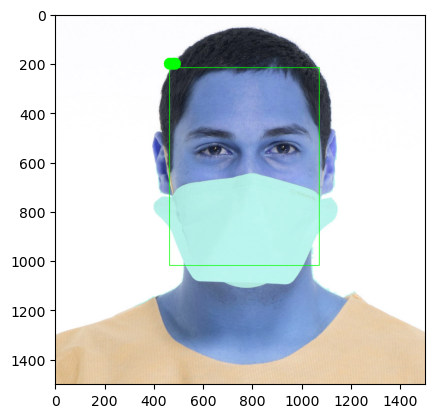

In [63]:
from matplotlib import pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
plt.imshow(image)
plt.show()